# Определение возраста покупателей по фотографии

***Описание проекта***

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 - Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.
 
***План выполнения проекта***

1. Провединие исследовательского анализа набора фотографий.

2. Подготовка данных к обучению.

3. Обучиние нейронной сети и рассчет её качества.

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >

# загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
#загрузка обучающей выборки

data = pd.read_csv('/datasets/faces/labels.csv') 

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


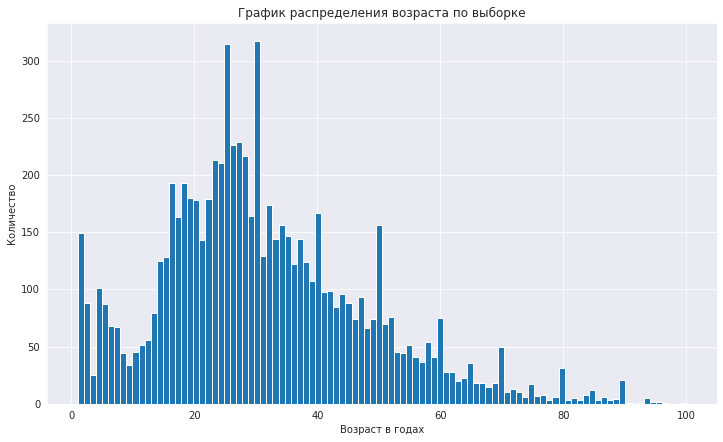

In [10]:
#оценим разброс цен на авто
sns.set_style('darkgrid')
data.real_age.hist(bins=100,figsize=(12,7))
plt.title('График распределения возраста по выборке')
plt.xlabel('Возраст в годах')
plt.ylabel('Количество')
plt.show()

Found 5694 images belonging to 1 classes.
Found 1897 images belonging to 1 classes.


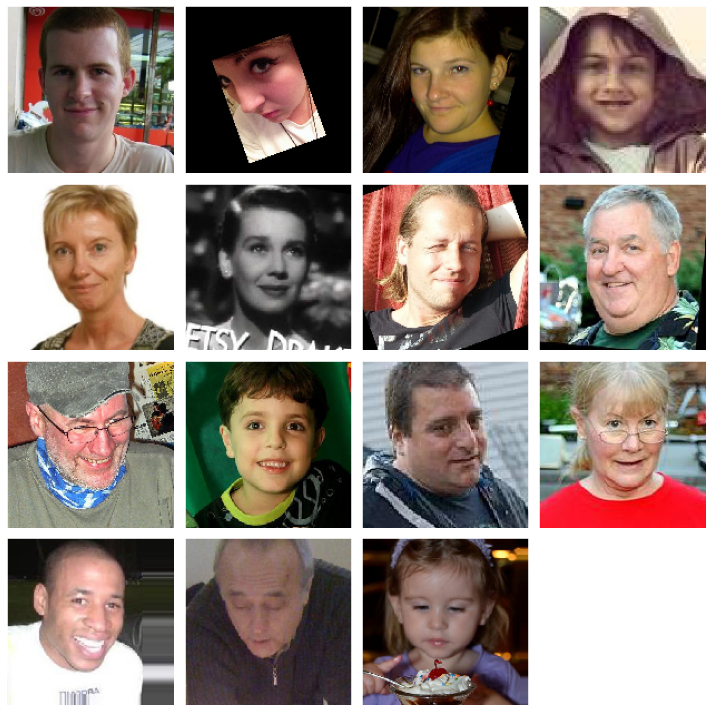

In [6]:
# вместо одного генератора сделайте два: train_datagen и validation_datagen
datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

train_datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345)

features, target = next(train_datagen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


***Вывод по анализу данных:***

1. Количество фотографий в датасете 7591.

2. Возраст большей части людей, представленных в датасете, находится в диапазоне от 20 до 40 лет.

3. Большая часть фото цветные, но есть и черно-белые. Лица людей есть в разных размерах, сфотографированы, как прямо, так и под углом, у некоторых людейесть очки на лице или предметы перед лицом (например, мороженое у девочки на последнем фото из выведенных)

В целом,  фотографии нормального качества и по ним хорошо видны черты лица.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-11-23 10:22:27.488674: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-23 10:22:28.665213: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 67s - loss: 212.7538 - mae: 10.5531 - val_loss: 843.6143 - val_mae: 24.1618
Epoch 2/10
356/356 - 39s - loss: 86.0308 - mae: 6.9785 - val_loss: 128.3406 - val_mae: 8.9223
Epoch 3/10
356/356 - 39s - loss: 57.6948 - mae: 5.7963 - val_loss: 88.5721 - val_mae: 7.1661
Epoch 4/10
356/356 - 39s - loss: 41.2168 - mae: 4.9327 - val_loss: 79.0349 - val_mae: 6.5958
Epoch 5/10
356/356 - 39s - loss: 33.7612 - mae: 4.4396 - val_loss: 92.0299 - val_mae: 7.2632
Epoch 6/10
356/356 - 39s - loss: 25.7606 - mae: 3.8822 - val_loss: 116.9404 - val_mae: 8.5929
Epoch 7/10
356/356 - 39s - loss: 21.3469 - mae: 3.5389 - val_loss: 77.6891 - val_mae: 6.8246
Epoch 8/10
356/356 - 39s - loss: 17.7747 - mae: 3.1841 - val_loss: 80.2801 - val_mae: 6.9840
Epoch 9/10
356/356 - 39s - loss: 15.8697 - mae: 2.9993 - val_loss: 66.0324 - val_mae: 6.0246
Epoch 10/10
356/356 - 40s - loss: 13.3186 - mae: 2.7666 - val_loss: 72.7218 - val_mae: 6.4232
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 72.7218 - mae: 6.4232
Test MAE: 6.4232





```

***Вывод по обучению модели:***

1. Для обучения данных была использована модель  сверточной нейронной сети на ResNet50


2. MAE за 10 эпох удалось уменьшить с 10.55 до 2.77 (возможно, при дальнейшем подборе параметров будет меньше). По условию задачи MAE не должно быть более 8, у нас получилось этого добиться.


## Анализ обученной модели

1. Модель достаточно быстро обучилась с испоьзованием GPU и нейронной сети. Но и датасет был небольшой.  


2. Погрешность в определении возраста составила в среднем 6 лет, что не много, но может быть существенно, когда определяем возраст с целью продажи алкоголя. Поэтому полученную модель лучше все доработать для дальнейшего использования на практике, ведь ошибка в этом вопросе чревата штрафами для магазина.  


## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы